In [1]:
!pip install pandas networkx matplotlib torch torch_geometric scikit-learn seaborn umap-learn

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import torch
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.manifold import TSNE # Per la visualizzazione
import seaborn as sns # Per plot più belli
from sklearn.metrics.pairwise import cosine_similarity # Per la similarità KNN-like
from torch_geometric.transforms import RandomLinkSplit

pd.set_option('display.max_colwidth', None)  # Mostra tutta la larghezza del contenuto della colonna
pd.set_option('display.max_columns', None)

# Verifica se CUDA è disponibile e imposta il device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Caricamento dataset

In [3]:
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
genres = pd.read_csv('./ml-100k/u.genre', sep='|', names=['genre', 'genre_id'], encoding='latin-1')
genres.head()

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [5]:
movies_cols = ['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{row["genre"]}' for index, row in genres.iterrows()]
movies = pd.read_csv('./ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
movies.head()

,movieId,title,release_date,video_release_date,IMDb_URL,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [6]:
"Ratings", ratings.columns

('Ratings',
 Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object'))

In [7]:
"Movies", movies.columns

('Movies',
 Index(['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
        'genre_unknown', 'genre_Action', 'genre_Adventure', 'genre_Animation',
        'genre_Children's', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
        'genre_Drama', 'genre_Fantasy', 'genre_Film-Noir', 'genre_Horror',
        'genre_Musical', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi',
        'genre_Thriller', 'genre_War', 'genre_Western'],
       dtype='object'))

# Preparazione vettori

## vettori utente

In [8]:
df_merged = pd.merge(ratings, movies, on='movieId', how='left')

# Identify genre columns
genre_cols = [f'genre_{row["genre"]}' for index, row in genres.iterrows()]

# 2. Melt the genre columns to have one row per user-movie-genre combination
# We only care about genres where the value is 1 (meaning the movie belongs to that genre)
df_genres_melted = df_merged.melt(id_vars=['userId', 'movieId'], value_vars=genre_cols,
                                  var_name='genre', value_name='is_genre')
df_genres_melted = df_genres_melted[df_genres_melted['is_genre'] == 1]

# 3. Group by userId and genre and count the occurrences
df_genre_counts = df_genres_melted.groupby(['userId', 'genre']).size().reset_index(name='review_count')

# 4. Pivot the table to get genres as columns
df_users = df_genre_counts.pivot_table(index='userId', columns='genre', values='review_count', fill_value=0)

# Reset index to make 'userId' a regular column and rename it
df_users = df_users.reset_index().rename(columns={'userId': 'user_id'})

# Display the resulting DataFrame
df_users.head()

genre,user_id,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,genre_unknown
0,1,75,42,12,25,91,25,5,107,2,1,13,13,5,44,43,52,25,6,1
1,2,10,3,1,4,16,9,0,35,1,2,2,1,4,16,4,12,3,0,0
2,3,14,4,0,0,12,10,1,22,0,2,5,2,11,5,8,21,5,0,0
3,4,8,4,0,0,4,4,1,6,0,0,1,1,5,3,6,11,2,0,0
4,5,56,33,14,29,82,9,0,27,2,1,28,12,3,19,33,19,14,2,1


normalizzazione colonne generi

In [9]:
# Calculate the sum of genre counts for each user
df_users['total_genre_reviews'] = df_users[genre_cols].sum(axis=1)

# Normalize the genre columns
# We divide each genre column by the 'total_genre_reviews' for that row
# We use .div() with axis=0 to perform row-wise division
df_users_normalized = df_users[genre_cols].div(
    df_users['total_genre_reviews'], axis=0
)

# Re-add the user_id column
df_users_normalized['user_id'] = df_users['user_id']

# Reorder columns to have user_id first
df_users_normalized = df_users_normalized[['user_id'] + genre_cols]

# Display the resulting normalized DataFrame
print("Normalized df_users head:")
df_users_normalized.head()

Normalized df_users head:


genre,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,0.001704,0.127768,0.071550,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221
1,2,0.000000,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000
2,3,0.000000,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000
3,4,0.000000,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000
4,5,0.002604,0.145833,0.085938,0.036458,0.075521,0.213542,0.023438,0.000000,0.070312,0.005208,0.002604,0.072917,0.031250,0.007812,0.049479,0.085938,0.049479,0.036458,0.005208


aggiunta colonna che indica la mediana dei rating espressi dall'utente

In [10]:
user_medians = ratings.groupby('userId')['rating'].median().reset_index()
user_medians = user_medians.rename(columns={'userId': 'user_id', 'rating': 'median'})
df_users_normalized = df_users_normalized.merge(user_medians, on='user_id', how='left')

df_users_normalized.head()

,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0.001704,0.127768,0.071550,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221,4.0
1,2,0.000000,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000,4.0
2,3,0.000000,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000,3.0
3,4,0.000000,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000,5.0
4,5,0.002604,0.145833,0.085938,0.036458,0.075521,0.213542,0.023438,0.000000,0.070312,0.005208,0.002604,0.072917,0.031250,0.007812,0.049479,0.085938,0.049479,0.036458,0.005208,3.0


## vettore film

In [11]:
df_movies = movies[['movieId'] + genre_cols].rename(columns={'movieId': 'movie_id'})
df_movies.head()

,movie_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [12]:
movie_medians = ratings.groupby('movieId')['rating'].median().reset_index()
movie_medians = movie_medians.rename(columns={'movieId': 'movie_id', 'rating': 'median'})

# 2. Unisci la mediana al DataFrame df_users
df_movies = df_movies.merge(movie_medians, on='movie_id', how='left')
df_movies.head()

,movie_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,4.0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,3.0


# Creazione grafo

In [13]:
B = nx.Graph()

nodi users

In [14]:
B.add_nodes_from(
    [
        (
            f"user_{uid}",
            {
                **{col: df_users_normalized.loc[df_users_normalized['user_id'] == uid, col].values[0] for col in df_users_normalized.columns if col != 'user_id'},
                'user_id': uid
            }
        )
        for uid in df_users_normalized['user_id']
    ],
    bipartite=0
)
print(f"Aggiunti {len(df_users_normalized)} nodi utente.")

Aggiunti 943 nodi utente.


In [15]:
print("Users node")
B.nodes['user_1']

Users node


{'bipartite': 0,
 'genre_unknown': 0.0017035775127768314,
 'genre_Action': 0.12776831345826234,
 'genre_Adventure': 0.07155025553662692,
 'genre_Animation': 0.020442930153321975,
 "genre_Children's": 0.04258943781942078,
 'genre_Comedy': 0.15502555366269166,
 'genre_Crime': 0.04258943781942078,
 'genre_Documentary': 0.008517887563884156,
 'genre_Drama': 0.18228279386712096,
 'genre_Fantasy': 0.0034071550255536627,
 'genre_Film-Noir': 0.0017035775127768314,
 'genre_Horror': 0.022146507666098807,
 'genre_Musical': 0.022146507666098807,
 'genre_Mystery': 0.008517887563884156,
 'genre_Romance': 0.07495741056218058,
 'genre_Sci-Fi': 0.07325383304940375,
 'genre_Thriller': 0.08858603066439523,
 'genre_War': 0.04258943781942078,
 'genre_Western': 0.010221465076660987,
 'median': 4.0,
 'user_id': 1}

nodi film

In [16]:
B.add_nodes_from(
    [
        (
            f"movie_{mid}",
            {
                'movie_id': mid,
                **{col: df_movies.loc[df_movies['movie_id'] == mid, col].values[0] for col in df_movies.columns if col != 'movie_id'}
            }
        )
        for mid in df_movies['movie_id']
    ],
    bipartite=1
)
print(f"Aggiunti {len(df_movies)} nodi film.")

Aggiunti 1682 nodi film.


In [17]:
print("Movies node")
B.nodes['movie_1']

Movies node


{'bipartite': 1,
 'movie_id': 1,
 'genre_unknown': 0,
 'genre_Action': 0,
 'genre_Adventure': 0,
 'genre_Animation': 1,
 "genre_Children's": 1,
 'genre_Comedy': 1,
 'genre_Crime': 0,
 'genre_Documentary': 0,
 'genre_Drama': 0,
 'genre_Fantasy': 0,
 'genre_Film-Noir': 0,
 'genre_Horror': 0,
 'genre_Musical': 0,
 'genre_Mystery': 0,
 'genre_Romance': 0,
 'genre_Sci-Fi': 0,
 'genre_Thriller': 0,
 'genre_War': 0,
 'genre_Western': 0,
 'median': 4.0}

In [18]:
for index, row in ratings.iterrows():
    user_node = f"user_{row['userId']}"
    movie_node = f"movie_{row['movieId']}"
    
    rating_value = row['rating']
    timestamp_value = row['timestamp']
    
    B.add_edge(user_node, movie_node, rating=rating_value, timestamp=timestamp_value)

print(f"\nGrafo Bipartito creato con successo!")
print(f"Numero totale di nodi nel grafo: {B.number_of_nodes()}")
print(f"Numero totale di archi nel grafo: {B.number_of_edges()}")


Grafo Bipartito creato con successo!
Numero totale di nodi nel grafo: 2625
Numero totale di archi nel grafo: 100000


Visualizzazione di un sottoinsieme: 5 utenti e 93 film correlati.


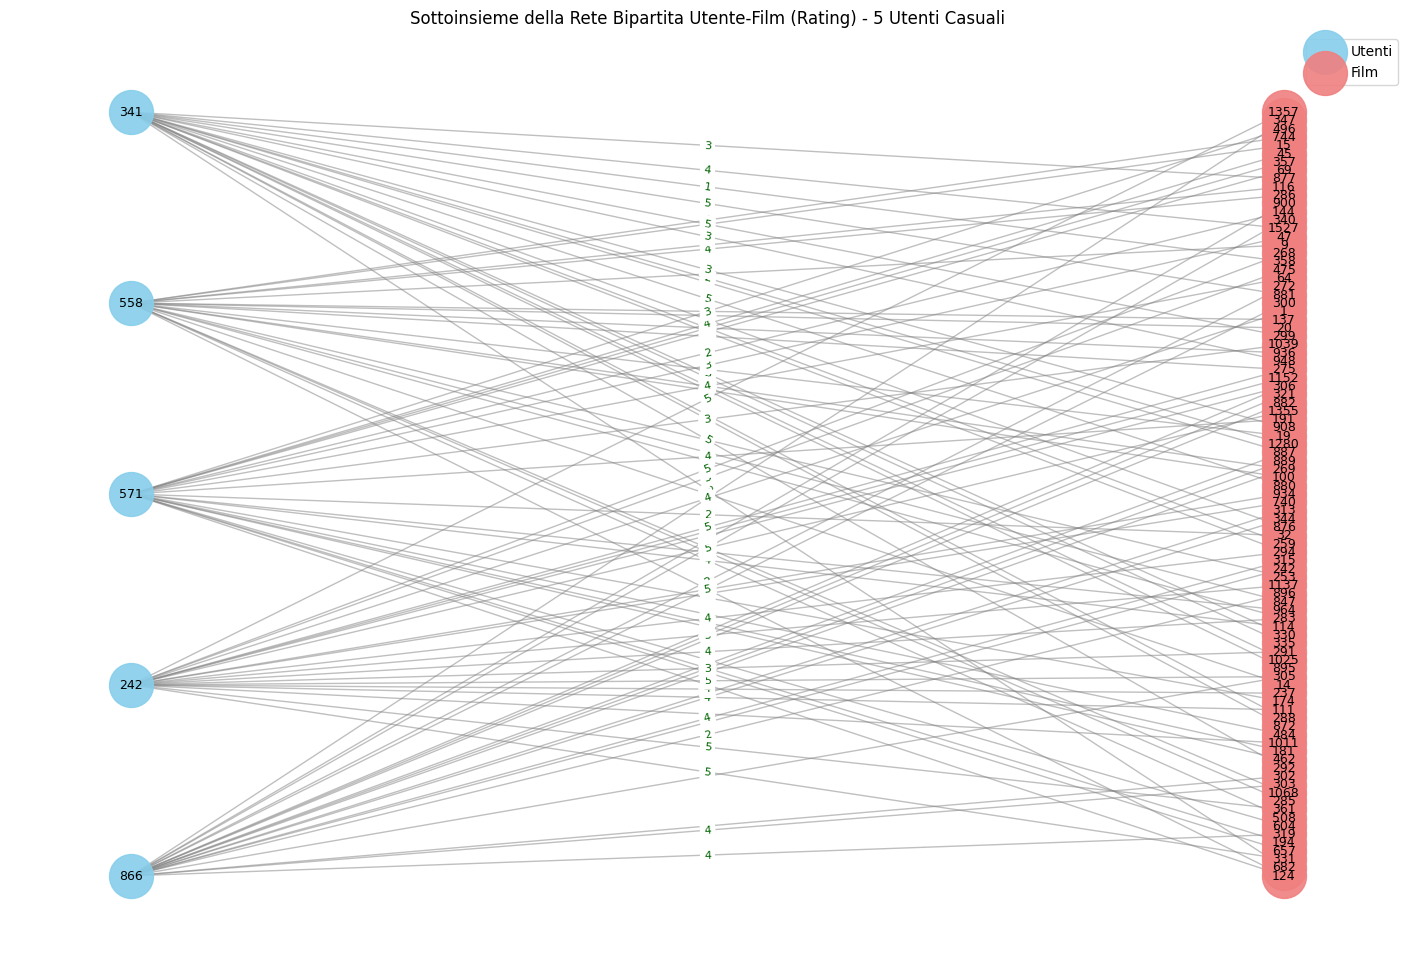

In [19]:
# Assicurati che il grafo 'B' sia già stato creato dal blocco precedente.

# Separa i nodi nei due set (utenti e film) usando l'attributo 'bipartite'
user_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
movie_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

# --- PARAMETRI PER IL SOTTOINSIEME ---
# Puoi scegliere quanti utenti visualizzare.
users_count = 5
sorted_users = df_users.loc[df_users[genre_cols].sum(axis=1).nsmallest(users_count).index]
min_user_ids = sorted_users['user_id'].tolist()
selected_user_nodes = [f"user_{uid}" for uid in min_user_ids if f"user_{uid}" in user_nodes]

# Trova tutti i film collegati a questi utenti selezionati
selected_movie_nodes = set()
for u_node in selected_user_nodes:
    for neighbor in B.neighbors(u_node):
        selected_movie_nodes.add(neighbor)

# Crea un sotto-grafo con solo i nodi selezionati e i loro archi
# Subgraph restituirà un grafo con solo i nodi e gli archi tra essi.
subgraph_nodes = set(selected_user_nodes).union(selected_movie_nodes)
B_sub = B.subgraph(subgraph_nodes)

print(f"Visualizzazione di un sottoinsieme: {len(selected_user_nodes)} utenti e {len(selected_movie_nodes)} film correlati.")

plt.figure(figsize=(18, 12)) # Aumenta ancora la dimensione per una migliore leggibilità

# Utilizza il layout specifico per grafi bipartiti sul sotto-grafo.
# È importante passare i nodi del sotto-grafo che appartengono al set degli utenti.
# Filtrali dal set originale di user_nodes.
sub_user_nodes_for_layout = {n for n in selected_user_nodes if n in B_sub.nodes()}
pos_sub = nx.bipartite_layout(B_sub, sub_user_nodes_for_layout)

# --- Disegna i nodi del sotto-grafo ---
# Nodi Utente: colorati di azzurro
nx.draw_networkx_nodes(B_sub, pos_sub, nodelist=list(sub_user_nodes_for_layout), node_color='skyblue', node_size=1000, label='Utenti', alpha=0.9)
# Nodi Film: colorati di rosso corallo
nx.draw_networkx_nodes(B_sub, pos_sub, nodelist=list(selected_movie_nodes), node_color='lightcoral', node_size=1000, label='Film', alpha=0.9)

# --- Disegna gli archi del sotto-grafo ---
nx.draw_networkx_edges(B_sub, pos_sub, width=1.0, alpha=0.5, edge_color='gray')

# --- Aggiungi le etichette ai nodi del sotto-grafo ---
# Modifica qui per stampare l'ID utente nei nodi bipartite 0 e l'ID film nei nodi bipartite 1
labels = {}
for node, data in B_sub.nodes(data=True):
    if data['bipartite'] == 0:  # Nodo utente
        labels[node] = node.replace('user_', '') # Mostra solo l'ID numerico dell'utente
    elif data['bipartite'] == 1: # Nodo film
        labels[node] = data['movie_id']  # Mostra l'ID del film

nx.draw_networkx_labels(B_sub, pos_sub, labels, font_size=9, font_color='black')

# --- Aggiungi etichette per i rating sugli archi ---
edge_labels = nx.get_edge_attributes(B_sub, 'rating')
nx.draw_networkx_edge_labels(B_sub, pos_sub, edge_labels=edge_labels, font_size=8, font_color='darkgreen')

# --- Aggiungi una legenda ---
plt.title(f"Sottoinsieme della Rete Bipartita Utente-Film (Rating) - {users_count} Utenti Casuali")
plt.legend(scatterpoints=1)
plt.axis('off') # Nasconde gli assi del grafico
plt.show()

# GrapSAGE

In [22]:
# Mapping dei nodi
node_to_idx = {node: i for i, node in enumerate(B.nodes())}
idx_to_node = {i: node for node, i in node_to_idx.items()}
num_nodes = B.number_of_nodes()

# Determina le chiavi da usare come feature per ciascuna partizione
user_keys = None
item_keys = None

for node in B.nodes():
    data = B.nodes[node]
    if data['bipartite'] == 0 and user_keys is None:
        user_keys = [k for k in data if k not in ('bipartite', 'user_id')]
    elif data['bipartite'] == 1 and item_keys is None:
        item_keys = [k for k in data if k not in ('bipartite', 'movie_id')]
    if user_keys and item_keys:
        break

# Controllo di sicurezza
if user_keys is None or item_keys is None:
    raise ValueError("Non sono riuscito a determinare le chiavi per utenti o item.")

# Costruisci le feature dinamicamente
features = []
for node in B.nodes():
    data = B.nodes[node]
    keys = user_keys if data['bipartite'] == 0 else item_keys
    feat = [float(data.get(k, 0.0)) for k in keys]  # fallback a 0.0 se mancante
    features.append(torch.tensor(feat, dtype=torch.float))

# Stack finale
x = torch.stack(features)

# Crea edge_index (bidirezionale)
edge_index_list = []
for u, v in B.edges():
    edge_index_list.append([node_to_idx[u], node_to_idx[v]])
    edge_index_list.append([node_to_idx[v], node_to_idx[u]])

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

# Sposta su device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
edge_index = edge_index.to(device)


print(f"Numero totale di nodi: {num_nodes}")
print(f"Numero totale di archi (bidirezionali): {edge_index.size(1)}")

# Conta i nodi per partizione
user_count = sum(1 for node in B.nodes if B.nodes[node]['bipartite'] == 0)
item_count = num_nodes - user_count
print(f"Nodi utente: {user_count}, Nodi item (film): {item_count}")

# Stampa un solo nodo utente
user_node = next(node for node in B.nodes if B.nodes[node]['bipartite'] == 0)
user_idx = node_to_idx[user_node]
print("\nNodo utente:")
print(f" Nodo: {user_node}")
print(f" Feature: {x[user_idx].cpu().numpy()}")

# Stampa un solo nodo item (film)
item_node = next(node for node in B.nodes if B.nodes[node]['bipartite'] == 1)
item_idx = node_to_idx[item_node]
print("\nNodo film:")
print(f" Nodo: {item_node}")
print(f" Feature: {x[item_idx].cpu().numpy()}")

Numero totale di nodi: 2625
Numero totale di archi (bidirezionali): 200000
Nodi utente: 943, Nodi item (film): 1682

Nodo utente:
 Nodo: user_1
 Feature: [1.70357747e-03 1.27768308e-01 7.15502575e-02 2.04429310e-02
 4.25894372e-02 1.55025557e-01 4.25894372e-02 8.51788744e-03
 1.82282791e-01 3.40715493e-03 1.70357747e-03 2.21465081e-02
 2.21465081e-02 8.51788744e-03 7.49574080e-02 7.32538328e-02
 8.85860324e-02 4.25894372e-02 1.02214655e-02 4.00000000e+00]

Nodo film:
 Nodo: movie_1
 Feature: [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4.]


In [49]:
# Assumiamo che B, x, edge_index, node_to_idx siano già stati creati
data = Data(x=x, edge_index=edge_index)

# Suddividiamo gli archi in 80% training, 10% validazione, 10% test
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=True,
    num_test=0.2, # 10% degli archi per il test
    split_labels=True
)

train_data, _, test_data = transform(data)

print("\nTrain Data:\n", train_data)
print("\nValidation Data:\n", val_data)
print("\nTest Data:\n", test_data)


Train Data:
 Data(x=[2625, 20], edge_index=[2, 140000], pos_edge_label=[70000], pos_edge_label_index=[2, 70000], neg_edge_label=[70000], neg_edge_label_index=[2, 70000])

Validation Data:
 Data(x=[2625, 20], edge_index=[2, 160000], pos_edge_label=[10000], pos_edge_label_index=[2, 10000], neg_edge_label=[10000], neg_edge_label_index=[2, 10000])

Test Data:
 Data(x=[2625, 20], edge_index=[2, 160000], pos_edge_label=[20000], pos_edge_label_index=[2, 20000], neg_edge_label=[20000], neg_edge_label_index=[2, 20000])


In [34]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import torch # Assicurati che torch sia importato

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        
        # Primo layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        
        # Layer intermedi
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        # Ultimo layer
        # NOTA: L'ultimo layer converte da hidden_channels a out_channels (dimensione dell'embedding finale)
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        # Applica le convoluzioni GraphSAGE
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            
            # Applica ReLU e Dropout solo per i layer INTERMEDI (non l'ultimo)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)

        return x

In [57]:
import torch # Assicurati che torch sia importato
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score 

def train():
    model.train()
    optimizer.zero_grad()

    node_embeddings = model(train_data.x, train_data.edge_index)
    
    pos_edge_embedding = node_embeddings[train_data.pos_edge_label_index[0]] * node_embeddings[train_data.pos_edge_label_index[1]]
    neg_edge_embedding = node_embeddings[train_data.neg_edge_label_index[0]] * node_embeddings[train_data.neg_edge_label_index[1]]

    pos_scores = pos_edge_embedding.sum(dim=1)
    neg_scores = neg_edge_embedding.sum(dim=1)

    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))])

    loss = F.binary_cross_entropy_with_logits(scores, labels)

    loss.backward()

    found_gradients = False
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            if grad_norm > 1e-9: 
                found_gradients = True

    optimizer.step()

    return loss.item()

@torch.no_grad() 
def test(): 
    model.eval() 
    
    node_embeddings = model(test_data.x, test_data.edge_index)

    pos_edge_embedding = node_embeddings[test_data.pos_edge_label_index[0]] * node_embeddings[test_data.pos_edge_label_index[1]]
    neg_edge_embedding = node_embeddings[test_data.neg_edge_label_index[0]] * node_embeddings[test_data.neg_edge_label_index[1]]

    pos_scores = pos_edge_embedding.sum(dim=1)
    neg_scores = neg_edge_embedding.sum(dim=1)

    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))])

    auc = roc_auc_score(labels.cpu().numpy(), scores.cpu().numpy())
    ap = average_precision_score(labels.cpu().numpy(), scores.cpu().numpy())
    
    return auc, ap

In [58]:
in_channels = data.x.size(1)
hidden_channels = 128
out_channels = 64 
num_layers = 3
model = GraphSAGE(in_channels, hidden_channels, out_channels, num_layers) # Assicurati che GraphSAGE sia la versione corretta con la forward rivista
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [89]:
model.load_state_dict(torch.load('weight_v0-3_layers-128_size.pth'))

/tmp/ipykernel_2967/1381538694.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weight_v0-3_layers-128_size.pth'))


<All keys matched successfully>

In [59]:
epochs = 500

train_losses = []
val_aucs = []
val_aps = []
epochs_list = [] # Per salvare il numero dell'epoca

for epoch in range(1, epochs + 1):
    loss = train()
    val_auc, val_ap = test()

    
    train_losses.append(loss)
    val_aucs.append(val_auc)
    val_aps.append(val_ap)
    epochs_list.append(epoch)

    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val_AUC: {val_auc:.4f}, Val_AP: {val_ap:.4f}')


test_auc, test_ap = test()
print(f'\nTest AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')


Epoch: 001, Loss: 4.6788, Val_AUC: 0.6409, Val_AP: 0.5947
Epoch: 010, Loss: 0.7122, Val_AUC: 0.5268, Val_AP: 0.4746
Epoch: 020, Loss: 0.6972, Val_AUC: 0.4424, Val_AP: 0.4553
Epoch: 030, Loss: 0.6872, Val_AUC: 0.5551, Val_AP: 0.5048
Epoch: 040, Loss: 0.6875, Val_AUC: 0.5459, Val_AP: 0.4978
Epoch: 050, Loss: 0.6834, Val_AUC: 0.6355, Val_AP: 0.5570
Epoch: 060, Loss: 0.6793, Val_AUC: 0.7224, Val_AP: 0.6278
Epoch: 070, Loss: 0.6737, Val_AUC: 0.7395, Val_AP: 0.6473
Epoch: 080, Loss: 0.6739, Val_AUC: 0.7066, Val_AP: 0.6005
Epoch: 090, Loss: 0.6751, Val_AUC: 0.7286, Val_AP: 0.6424
Epoch: 100, Loss: 0.6729, Val_AUC: 0.7415, Val_AP: 0.6543
Epoch: 110, Loss: 0.6643, Val_AUC: 0.7454, Val_AP: 0.6555
Epoch: 120, Loss: 0.6609, Val_AUC: 0.7565, Val_AP: 0.6923
Epoch: 130, Loss: 0.6567, Val_AUC: 0.7606, Val_AP: 0.7045
Epoch: 140, Loss: 0.6584, Val_AUC: 0.7642, Val_AP: 0.7108
Epoch: 150, Loss: 0.6574, Val_AUC: 0.7646, Val_AP: 0.6965
Epoch: 160, Loss: 0.6495, Val_AUC: 0.7664, Val_AP: 0.7048
Epoch: 170, Lo

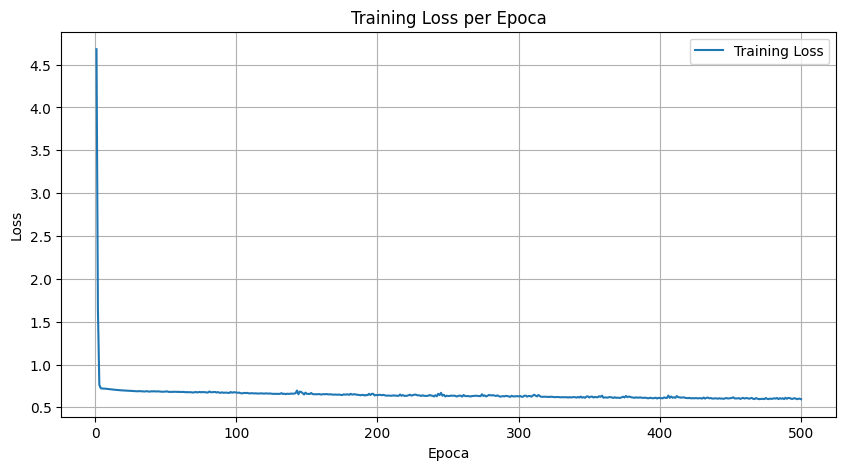

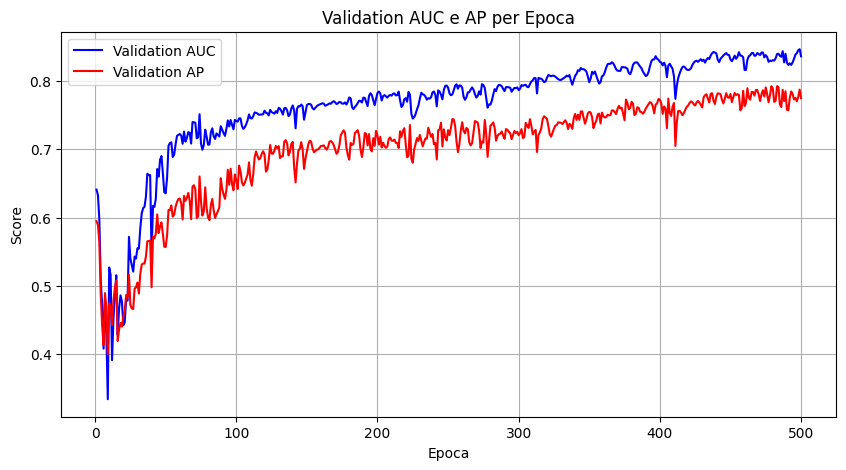

In [60]:
import matplotlib.pyplot as plt

# Assicurati di aver eseguito il ciclo di training modificato sopra
# per avere le liste train_losses, val_aucs, val_aps, epochs_list popolate.

# --- Plot della Loss di Training ---
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.title('Training Loss per Epoca')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot di AUC e AP di Validazione ---
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, val_aucs, label='Validation AUC', color='blue')
plt.plot(epochs_list, val_aps, label='Validation AP', color='red')
plt.title('Validation AUC e AP per Epoca')
plt.xlabel('Epoca')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
version = 'v0'
torch.save(model.state_dict(), f'weight_{version}-{epochs}_epochs-{num_layers}_layers-{out_channels}_size.pth')

In [90]:
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index)


def get_node_id_field(node_id):
    """
    Recupera il campo ID specifico (user_id o movie_id) per un nodo dal grafo NetworkX B.
    """
    node_attrs = B.nodes[node_id]
    if node_attrs['bipartite'] == 0: # È un utente
        return node_attrs.get('user_id', node_id)
    else: # È un film (o item)
        return node_attrs.get('movie_id', node_id)

In [91]:
# --- ESEMPIO 1: Raccomandare FILM a un UTENTE ---
print("===== ESEMPIO 1: Raccomandare FILM a un UTENTE =====")

start_user_original_id = next(node for node, attrs in B.nodes(data=True) if attrs['bipartite'] == 0)
start_user_idx = node_to_idx[start_user_original_id]
start_user_embedding = node_embeddings[start_user_idx]

# Stampa solo l'ID dell'utente di partenza
print(f"Utente di Partenza: '{get_node_id_field(start_user_original_id)}'")

# Trova tutti i film a cui l'utente è già collegato (ID originali)
already_watched_movies_ids = set(B.neighbors(start_user_original_id))

# Candidati per la raccomandazione: tutti i nodi di TIPO FILM che l'utente NON ha ancora visto
candidate_movie_original_ids = [
    node_id for node_id, attrs in B.nodes(data=True)
    if attrs['bipartite'] == 1 and node_id not in already_watched_movies_ids
]

# Converti gli ID originali dei film candidati nei loro indici PyTorch Geometric
candidate_movie_indices = [node_to_idx[oid] for oid in candidate_movie_original_ids]
candidate_movie_embeddings = node_embeddings[candidate_movie_indices]

# Calcola i punteggi di connessione tra l'utente e i film candidati
reco_scores = (start_user_embedding * candidate_movie_embeddings).sum(dim=1)

# Ordina i candidati e prendi i Top-K
top_k = 5
sorted_reco_scores, sorted_reco_indices = torch.sort(reco_scores, descending=True)

recommended_movie_indices = [candidate_movie_indices[i] for i in sorted_reco_indices[:top_k]]
recommended_con_scores = sorted_reco_scores[:top_k]

print(f"\nTop {top_k} raccomandazioni di FILM per l'utente '{get_node_id_field(start_user_original_id)}':")
for movie_idx, score in zip(recommended_movie_indices, recommended_con_scores):
    movie_original_id = idx_to_node[movie_idx] # Converti l'indice PyG in ID originale

    # Stampa solo l'ID del film raccomandato
    print(f"  Film ID: '{get_node_id_field(movie_original_id)}', Probabilità: {torch.sigmoid(score).item():.4f}")

===== ESEMPIO 1: Raccomandare FILM a un UTENTE =====
Utente di Partenza: '1'

Top 5 raccomandazioni di FILM per l'utente '1':
  Film ID: '515', Probabilità: 0.9100
  Film ID: '405', Probabilità: 0.9038
  Film ID: '498', Probabilità: 0.8980
  Film ID: '483', Probabilità: 0.8975
  Film ID: '449', Probabilità: 0.8960


In [92]:
print("===== ESEMPIO 2: Raccomandare FILM SIMILI a un FILM dato =====")

start_movie_original_id = next(node for node, attrs in B.nodes(data=True) if attrs['bipartite'] == 1)
start_movie_idx = node_to_idx[start_movie_original_id]
start_movie_embedding = node_embeddings[start_movie_idx]

# Stampa solo l'ID del film di partenza
print(f"\nFilm di Partenza Selezionato (bipartite=1): '{get_node_id_field(start_movie_original_id)}'")

# Candidati per la raccomandazione: tutti i nodi di TIPO FILM ECCETTO il film di partenza stesso
candidate_similar_movie_ids = [
    node_id for node_id, attrs in B.nodes(data=True)
    if attrs['bipartite'] == 1 and node_id != start_movie_original_id
]

if not candidate_similar_movie_ids:
    print(f"Non ci sono altri film nel grafo simili a '{get_node_id_field(start_movie_original_id)}'.")
else:
    # Converti gli ID originali dei film candidati nei loro indici PyTorch Geometric
    candidate_similar_movie_indices = [node_to_idx[oid] for oid in candidate_similar_movie_ids]
    candidate_similar_movie_embeddings = node_embeddings[candidate_similar_movie_indices]

    # Calcola la similarità tra il film di partenza e gli altri film candidati
    similarity_scores = (start_movie_embedding * candidate_similar_movie_embeddings).sum(dim=1)

    # Ordina i candidati     e prendi i Top-K
    top_k = 5
    sorted_similarity_scores, sorted_similar_indices = torch.sort(similarity_scores, descending=True)

    recommended_similar_movie_indices = [candidate_similar_movie_indices[i] for i in sorted_similar_indices[:top_k]]
    recommended_similar_scores = sorted_similarity_scores[:top_k]
    
    print(f"\nTop {top_k} FILM SIMILI a '{get_node_id_field(start_movie_original_id)}':")
    for similar_movie_idx, score in zip(recommended_similar_movie_indices, recommended_similar_scores):
        similar_movie_original_id = idx_to_node[similar_movie_idx] # Converti l'indice PyG in ID originale

        # Stampa solo l'ID del film simile raccomandato
        print(f"  Film ID: '{get_node_id_field(similar_movie_original_id)}', Similarità (Probabilità): {torch.sigmoid(score).item():.4f}")

===== ESEMPIO 2: Raccomandare FILM SIMILI a un FILM dato =====

Film di Partenza Selezionato (bipartite=1): '1'

Top 5 FILM SIMILI a '1':
  Film ID: '50', Similarità (Probabilità): 0.9681
  Film ID: '181', Similarità (Probabilità): 0.9637
  Film ID: '172', Similarità (Probabilità): 0.9440
  Film ID: '121', Similarità (Probabilità): 0.9393
  Film ID: '176', Similarità (Probabilità): 0.9261


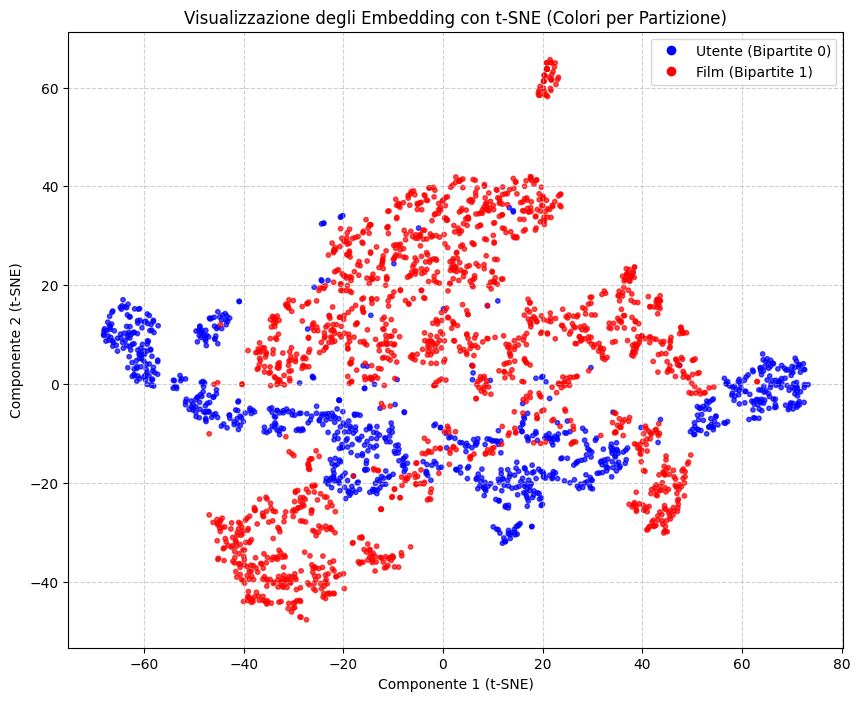

In [71]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch

embeddings_np = node_embeddings.cpu().numpy()


tsne = TSNE(n_components=2, perplexity=30, random_state=42)


embeddings_2d_tsne = tsne.fit_transform(embeddings_np)

try:
    # Colori basati sulla partizione: 0 per Utente, 1 per Film
    colors = []
    for i in range(len(embeddings_np)):
        original_node_id = idx_to_node[i]
        node_type = B.nodes[original_node_id]['bipartite']
        colors.append('blue' if node_type == 0 else 'red') # Blu per Utenti, Rosso per Film

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], 
                          c=colors, s=10, alpha=0.7)
    plt.title('Visualizzazione degli Embedding con t-SNE (Colori per Partizione)')
    plt.xlabel('Componente 1 (t-SNE)')
    plt.ylabel('Componente 2 (t-SNE)')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Crea una legenda manuale
    handles = [plt.Line2D([0], [0], marker='o', color='w', label='Utente (Bipartite 0)', 
                          markerfacecolor='blue', markersize=8),
               plt.Line2D([0], [0], marker='o', color='w', label='Film (Bipartite 1)', 
                          markerfacecolor='red', markersize=8)]
    plt.legend(handles=handles)
    plt.show()

except NameError:
    print("\nPer plottare con colori per partizione, assicurati che 'B' e 'idx_to_node' siano definiti.")
except Exception as e:
    print(f"\nErrore durante il plotting con colori per partizione (t-SNE): {e}")

In [93]:
movies[movies['movieId'].isin([1, 50, 181, 172])]

,movieId,title,release_date,video_release_date,IMDb_URL,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
49,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%20(1977),0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
171,172,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,"http://us.imdb.com/M/title-exact?Empire%20Strikes%20Back,%20The%20(1980)",0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0
180,181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%20the%20Jedi%20(1983),0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
